1. RGB images

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.optimizers import Adam

In [2]:
IMG_SIZE = (128, 128)
DATA_DIR = "Dataset/preprocessed_images"
META_CSV = "Dataset/meta_train.csv"
EPOCHS = 15
BATCH_SIZE = 32

In [ ]:
meta_df = pd.read_csv(META_CSV)
meta_df.dropna(subset=['variety'], inplace=True)

le = LabelEncoder()
meta_df['variety_encoded'] = le.fit_transform(meta_df['variety'])
num_classes = len(le.classes_)

In [ ]:
X, y = [], []

for _, row in meta_df.iterrows():
    red_img_name = row['image_id'].replace(".jpg", "_red.jpg")
    img_path = os.path.join(DATA_DIR, row['label'], red_img_name)

    if not os.path.exists(img_path):
        continue

    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    X.append(img_array)
    y.append(row['variety_encoded'])

X = np.array(X)
y = to_categorical(y, num_classes=num_classes)

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [6]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,930 (12.61 MB)

 Trainable params: 3,305,930 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 45s 170ms/step - accuracy: 0.6766 - loss: 1.1876 - val_accuracy: 0.7541 - val_loss: 0.7481
Epoch 2/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 49s 188ms/step - accuracy: 0.7849 - loss: 0.6598 - val_accuracy: 0.8559 - val_loss: 0.4650
Epoch 3/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 52s 198ms/step - accuracy: 0.8583 - loss: 0.4360 - val_accuracy: 0.8766 - val_loss: 0.3953
Epoch 4/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 54s 206ms/step - accuracy: 0.9177 - loss: 0.2570 - val_accuracy: 0.9313 - val_loss: 0.2500
Epoch 5/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 54s 207ms/step - accuracy: 0.9424 - loss: 0.1656 - val_accuracy: 0.9270 - val_loss: 0.2688
Epoch 6/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 55s 210ms/step - accuracy: 0.9637 - loss: 0.1033 - val_accuracy: 0.9395 - val_loss: 0.2388
Epoch 7/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 55s 212ms/step - accuracy: 0.9738 - loss: 0.0917 - val_accuracy: 0.9308 - val_loss: 0.2885
Epoch 8/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 56s 215ms/step - accuracy: 0.9821 - loss: 0

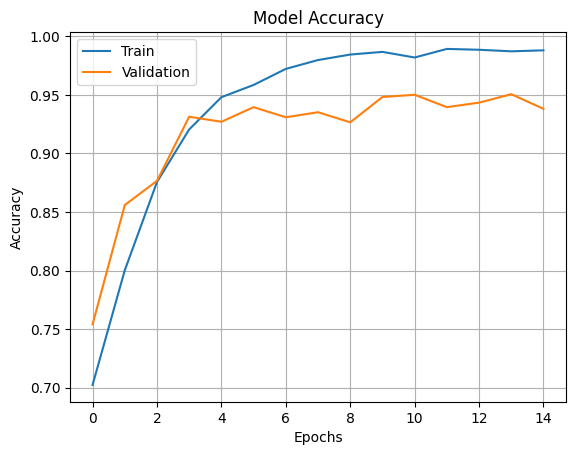

In [8]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
model.save("variety_red_model.h5")